# VGG16 Boat types recognition - transfer learning

Creating valid set

In [1]:
import os
import shutil
import random

In [2]:
#os.mkdir('data/boats/valid')

In [3]:
#train_directory = 'data/boats/train'
#valid_directory = 'data/boats/valid'

In [4]:
def create_valid_set(train_directory, valid_directory, sample_share=0.3):
    
    #creates subfolders in valid folder with all classes from the train set
    
    #gets names of all classes from train set
    
    names_list = os.listdir('{}'.format(train_directory))
    
    #makes new directories in valid folder
    
    for i in range(len(names_list)):
        name = names_list[i]
        if name not in os.listdir('{}'.format(valid_directory)):
            os.mkdir('{}/{}'.format(valid_directory, name))
    
    #moves randomly choosen files from train folder to valid folder
    
    for i in range(len(names_list)):
        name = names_list[i]
        picture_names = os.listdir('{}/{}'.format(train_directory, name))
        picture_number = len(picture_names)
        picture_nuber_to_move = int(picture_number*sample_share)
        picture_samples = random.sample(picture_names, picture_nuber_to_move)
        for j in range(len(picture_samples)):
            picture_name = picture_samples[j]
            os.rename('{}/{}/{}'.format(train_directory, name, picture_name), '{}/{}/{}'.format(valid_directory, name, picture_name))
            

In [5]:
#create_valid_set(train_directory, valid_directory)

Model training

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
torch.cuda.set_device(0)

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.backends.cudnn.enabled


True

In [11]:
PATH = "data/boats/"
sz = 224
arch = vgg16

In [12]:
files = os.listdir(f'{PATH}valid/cruise_ship')[:5]
files

['cruise-ship-cruise-norwegian-jade-3526976.jpg',
 'cruise-ship-cruise-ship-vacations-2860249.jpg',
 'cruise-north-america-passenger-ship-1267024.jpg',
 'cruise-ship-shelf-princess-sunset-3547180.jpg',
 'ship-cruise-ship-cruise-vacations-3480724.jpg']

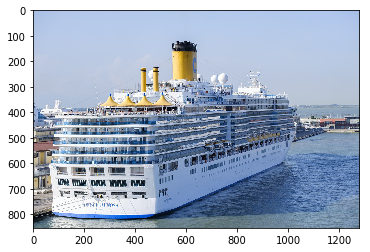

In [13]:
img = plt.imread(f'{PATH}valid/cruise_ship/{files[4]}')
plt.imshow(img);

In [14]:
img.shape

(853, 1280, 3)

In [15]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),bs=10)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.4)

Using lr_find() to find highest learning rate where loss is still clearly improving

In [16]:
lrf=learn.lr_find()

 68%|██████▊   | 70/103 [00:01<00:43,  1.31s/it, loss=1.75]


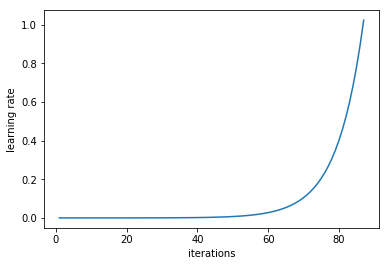

In [17]:
learn.sched.plot_lr()

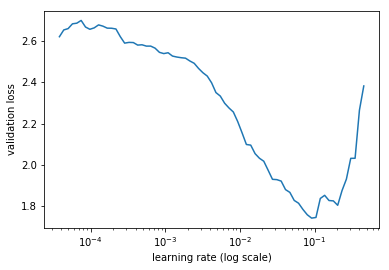

In [18]:
learn.sched.plot()

Training last layer from precomputed activations for 2 epochs

In [19]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.954362   0.57456    0.811927  
    1      0.751955   0.559868   0.823394                   



[array([0.55987]), 0.8233944909014833]

Training last layer with data augmentation

In [20]:
tfms = tfms_from_model(vgg16, sz, aug_tfms=transforms_side_on, max_zoom=1.1, crop_type=CropType.NO)

In [21]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [22]:
ims = np.stack([get_augs() for i in range(6)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


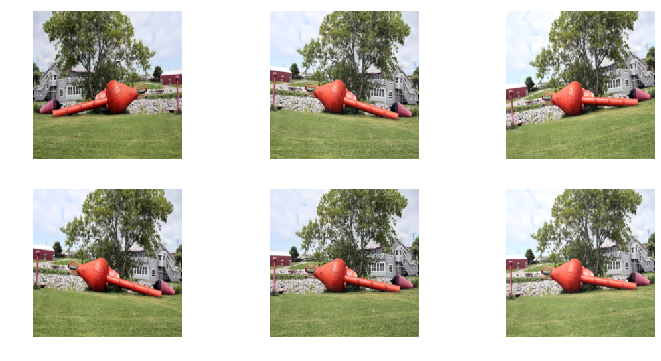

In [23]:
plots(ims, rows=2)

In [24]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [25]:
learn.precompute = False

In [26]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.57661    0.443782   0.83945   
    1      0.525968   0.426766   0.862385                    
    2      0.460153   0.442126   0.850917                    



[array([0.44213]), 0.8509174259977603]

Training all layers, but with different learning rates, since last layers need more tuning.

In [27]:
learn.unfreeze()

In [28]:
lr=np.array([1e-4,1e-3,0.01])

In [29]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.70172    0.506359   0.832569  
    1      0.651758   0.431508   0.87156                     
    2      0.387997   0.443098   0.864679                    



[array([0.4431]), 0.8646788931357752]

In [30]:
learn.save('vgg16_224')

In [31]:
learn.precompute = False

In [32]:
learn.load('vgg16_224')

Visualising the results

In [33]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [34]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 14   0   0   0   0   0   2   0   4]
 [  0  64   2   0   0   0   0   0   6]
 [  0   1  19   1   0   0   0   0   4]
 [  0   3   4   1   1   0   0   0   0]
 [  0   0   1   0  69   0   3   0   0]
 [  0   1   0   0   0   1   3   0   2]
 [  2   0   0   0   1   1  60   0   8]
 [  0   0   0   0   0   0   0   9   3]
 [  1   1   0   0   0   0   2   0 142]]


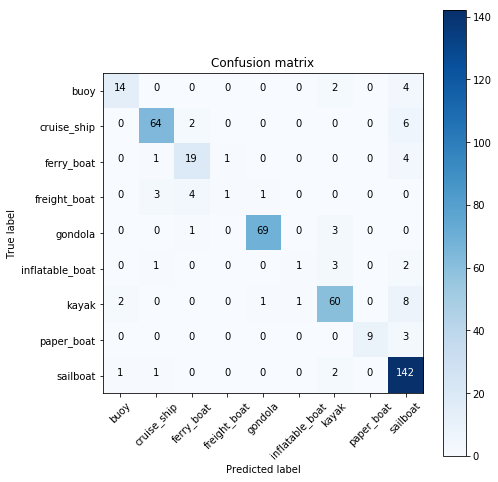

In [36]:
plot_confusion_matrix(cm, data.classes, figsize=(7,7))

Checking some misslasified pictures

In [37]:
false_predictions = y != preds

In [38]:
l = []
n = 0
for i in false_predictions:
    if i == True:
        l.append(n)
    n += 1

In [39]:
l[:7]

[1, 2, 3, 4, 7, 13, 28]

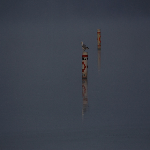

In [40]:
fn = data.val_ds.fnames[4]
Image.open(PATH + fn).resize((150, 150))

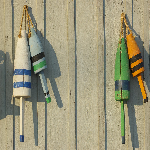

In [41]:
fn = data.val_ds.fnames[13]
Image.open(PATH + fn).resize((150, 150))

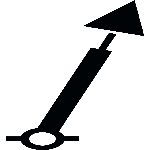

In [42]:
fn = data.val_ds.fnames[14]
Image.open(PATH + fn).resize((150, 150))

Testing the model on my own picture

In [43]:
#os.mkdir('data/boats/test')

In [52]:
!ls data/boats/test  

Η-_0003_drz-canaves_Q1A0638-500x350.jpg


In [46]:
fn = 'test/'+ 'Η-_0003_drz-canaves_Q1A0638-500x350.jpg'
fn

'test/Η-_0003_drz-canaves_Q1A0638-500x350.jpg'

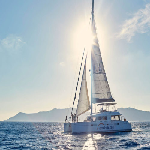

In [47]:
Image.open(PATH + fn).resize((150, 150))

In [48]:
learn.precompute = False

In [49]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

8

In [54]:
data.classes[8]

'sailboat'